In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys

import pandas as pd
import numpy as np
import pickle as pkl
import sklearn as skl
import sklearn.preprocessing

import matplotlib as mpl

import matplotlib.pyplot as plt

In [3]:
np.random.seed(0)

np.random

cell_time = np.random.uniform(-2 * np.pi, 2 * np.pi, [500, 1])

gene01_phase = np.random.uniform(0, 2 * np.pi, [1, 200])
gene01_time = np.random.normal(0, 0.1, [1, 200])
gene01_speed = np.random.uniform(0.5, 1.5, [1, 200])

gene0_phase = np.random.uniform(0, 2 * np.pi, [1, 500])

gene1_time = np.random.normal(0, 0.1, [1, 200])
gene1_speed = np.random.uniform(0.5, 1.5, [1, 200])

In [4]:
gene0 = np.sin(cell_time - gene0_phase)
gene1 = np.tanh(gene1_speed * (cell_time - gene1_time))
gene01 = np.sin(cell_time - gene01_phase) + np.tanh(gene01_speed * (cell_time - gene01_time)) / 2

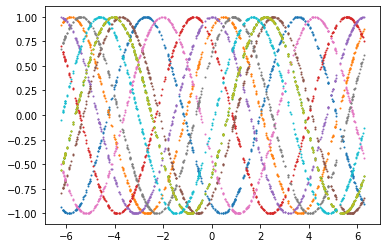

In [5]:
for i in range(10):
    plt.scatter(x=cell_time, y=gene0[:, i], s=1)

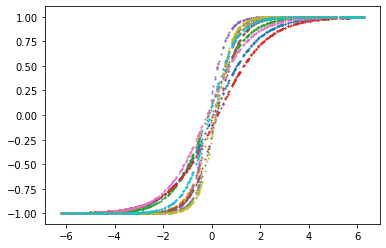

In [6]:
for i in range(10):
    plt.scatter(x=cell_time, y=gene1[:, i], s=1)

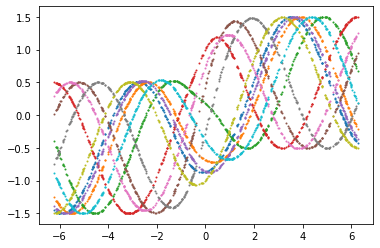

In [7]:
for i in range(10):
    plt.scatter(x=cell_time, y=gene01[:, i], s=1)

In [8]:
gene = np.hstack([gene0, gene1, gene01])
gene.shape

(500, 900)

In [9]:
from sklearn.decomposition import PCA
pc = PCA(n_components=10, copy=True, whiten=False, svd_solver="auto",
         tol=0.0, iterated_power="auto", random_state=None).fit_transform(gene)

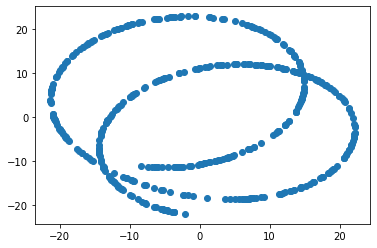

In [10]:
plt.scatter(pc[:, 1], pc[:, 2])

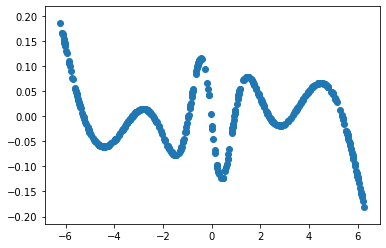

In [11]:
plt.scatter(cell_time, pc[:, 6])

In [12]:
import cyclum

In [13]:
from cyclum.core import _BaseCyclum

In [14]:
import tensorflow as tf
import time

In [50]:
class Experiment(_BaseCyclum):
    def __init__(self, Y):
        super().__init__(Y, 1)
        encoder = _BaseCyclum.nonlinear_encoder([0], [30, 20], 'tanh')
        decoder = _BaseCyclum.circular_decoder([0]) + _BaseCyclum.nonlinear_decoder([0], [1], 'tanh')
        self.build(encoder, decoder)
        
    def train(self):
        """
        train the model

        :return:
        """

        graph = tf.get_default_graph()

        R = ((tf.nn.l2_loss(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder0/layer0/W')[0]) +
              tf.nn.l2_loss(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder0/layer1/W')[0]) +
              tf.nn.l2_loss(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder0/output/W')[0])
              ) / 10 +
             (tf.nn.l2_loss(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'decoder0/output/W')[0]) +
              tf.nn.l2_loss(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'decoder1/output/W')[0])
              )
             )

        L = tf.reduce_sum((self.Y - self.Y2) ** 2) / (2 * self.N)

        opt = tf.train.AdamOptimizer(0.01).minimize(L + R * 1.0)

        t0 = time.time()

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        def unit_train(opt, n_step, losses, sess):
            t1 = time.time()
            for i in range(n_step):
                sess.run(opt)
                if (i + 1) % 2000 == 0:
                    print('step %5d: loss ' % (i + 1), end="")
                    print(self.sess.run(losses), end="")
                    print(' time %.2f' % (time.time() - t1))
                    t1 = time.time()

        unit_train(opt, 10000, [L, R], self.sess)

        self.pseudotime = self.sess.run(self.X)
        self.rotation = self.sess.run(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'decoder0/output/W')[0])
        
        print('Full time %.2f' % (time.time() - t0))

In [51]:
model = Experiment(gene)

<tf.Variable 'encoder0_5/layer0/W:0' shape=(900, 30) dtype=float32_ref>
<tf.Variable 'encoder0_5/layer1/W:0' shape=(30, 20) dtype=float32_ref>
<tf.Variable 'encoder0_5/output/W:0' shape=(20, 1) dtype=float32_ref>
<tf.Variable 'decoder1_5/layer0/W:0' shape=(1, 1) dtype=float32_ref>
<tf.Variable 'decoder1_5/output/W:0' shape=(1, 900) dtype=float32_ref>


In [52]:
model.train()

step  2000: loss [93.69132, 9.021267e-07] time 3.00
step  4000: loss [89.93354, 3.34392e-06] time 2.66
step  6000: loss [41.238598, 4.51874e-06] time 2.68
step  8000: loss [36.403526, 2.559358e-06] time 2.72
step 10000: loss [36.294003, 2.8100376e-06] time 2.78
Full time 14.34


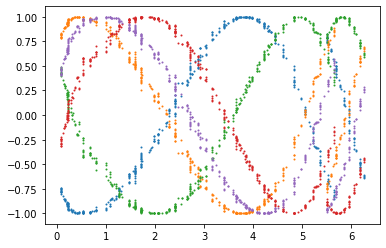

In [53]:
for i in range(5):
    plt.scatter(x=model.pseudotime % (2 * np.pi), y=gene0[:, i], s=1)

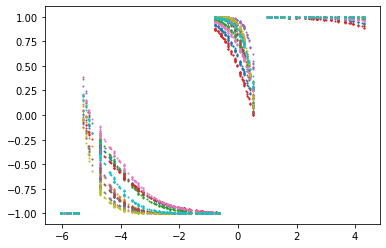

In [54]:
for i in range(10):
    plt.scatter(x=model.pseudotime, y=gene1[:, i], s=1)

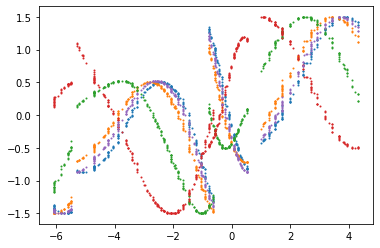

In [55]:
for i in range(5):
    plt.scatter(x=model.pseudotime, y=gene01[:, i], s=1)

Text(0, 0.5, 'predicted timing')

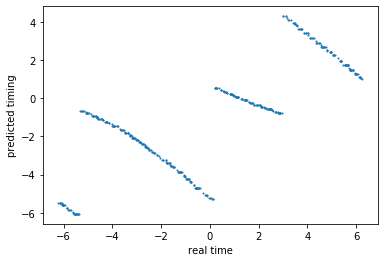

In [56]:
plt.scatter(y=model.pseudotime, x=cell_time, s=1)
plt.xlabel('real time')
plt.ylabel('predicted timing')